Mon Nov 11 13:46:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   GI   CI        PID   Type   Process name                            GPU Memory |
|        ID   ID                                                             Usage      |
|=======================================================================================|
|  No running processes found                                                           |
+---------------------------------------------------------------------------------------+

In [1]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
#from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
#from arff2pandas import a2p

import scipy
from scipy import io
import os
from pathlib import Path

In [2]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Verifica se 'mps' è disponibile su Apple Silicon

device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")

 

# Conferma del dispositivo selezionato

print("Using device:", device)

Using device: mps




In this tutorial, you'll learn how to detect anomalies in Time Series data using an LSTM Autoencoder. You're going to use real-world ECG data from a single patient with heart disease to detect abnormal hearbeats.

    Read the tutorial
    Run the notebook in your browser (Google Colab)
    Read the Getting Things Done with Pytorch book

By the end of this tutorial, you'll learn how to:

    Prepare a dataset for Anomaly Detection from Time Series Data
    Build an LSTM Autoencoder with PyTorch
    Train and evaluate your model
    Choose a threshold for anomaly detection
    Classify unseen examples as normal or anomaly



### Data

The dataset contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

    An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. Source

We have 5 types of hearbeats (classes):

    Normal (N)
    R-on-T Premature Ventricular Contraction (R-on-T PVC)
    Premature Ventricular Contraction (PVC)
    Supra-ventricular Premature or Ectopic Beat (SP or EB)
    Unclassified Beat (UB).

    Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle. Frequency: 60–100 per minute (Humans) Duration: 0.6–1 second (Humans) Source

The dataset is available on my Google Drive. Let's get it:

In [3]:
os.listdir()

['.DS_Store',
 'requirements.txt',
 'autoencoder_first_try.ipynb',
 '.ipynb_checkpoints',
 'venv',
 'autoencoder_tutorial.ipynb',
 'data']

In [4]:
os.getcwd()

'/Users/stephanehess/Documents/CAS_AML/autoencoder_timeseries_pytorch'

## Load Data and Sound Meta-Data:

### Define file_paths: 

In [5]:
root_path = Path('/Users/stephanehess/Documents/CAS_AML/autoencoder_timeseries_pytorch')
path_to_data = root_path/'data/MICRO_Motion_Capture/movement_data'
path_to_sound_meta_data = root_path/'data/MICRO_Motion_Capture/sound_data'

In [6]:
os.chdir(path_to_data)

In [7]:
os.listdir()

['NM0001.tsv',
 'NM0002.tsv',
 'NM0003.tsv',
 'NM0007.tsv',
 'NM0012.tsv',
 'NM0006.tsv',
 'NM0010.tsv',
 'NM0004.tsv',
 'NM0005.tsv',
 'NM0011.tsv',
 'NM0008.tsv',
 'NM0009.tsv']

Get a list of all data files:

In [8]:
nm_files = os.listdir()
nm_files.sort()
nm_files

['NM0001.tsv',
 'NM0002.tsv',
 'NM0003.tsv',
 'NM0004.tsv',
 'NM0005.tsv',
 'NM0006.tsv',
 'NM0007.tsv',
 'NM0008.tsv',
 'NM0009.tsv',
 'NM0010.tsv',
 'NM0011.tsv',
 'NM0012.tsv']

In [9]:
#nm12raw = pd.read_csv('NM0012.tsv', delimiter='\t', encoding='utf-8', skiprows=10, low_memory=False)
#nm12raw.drop(nm12raw.columns[len(nm12raw.columns)-1], axis=1, inplace=True)

### Load all data into a dictionary (each entry is the data from one group of study participants:

In [10]:
nm_data_raw = {}

i=1

for filename in nm_files:
    print(filename)
    nm_data_raw[i] = pd.read_csv(filename, delimiter='\t', encoding='utf-8', skiprows=10, low_memory=False)
    nm_data_raw[i].drop(nm_data_raw[i].columns[len(nm_data_raw[i].columns)-1], axis=1, inplace=True)
    i = i+1

NM0001.tsv
NM0002.tsv
NM0003.tsv
NM0004.tsv
NM0005.tsv
NM0006.tsv
NM0007.tsv
NM0008.tsv
NM0009.tsv
NM0010.tsv
NM0011.tsv
NM0012.tsv


### Have a look:

In [11]:
nm_data_raw.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

In [12]:
nm_data_raw[2].head()

,S2 X,S2 Y,S2 Z,S5 X,S5 Y,S5 Z,S6 X,S6 Y,S6 Z,S8 X,...,S12 Z,Corner1 X,Corner1 Y,Corner1 Z,Corner2 X,Corner2 Y,Corner2 Z,Corner3 X,Corner3 Y,Corner3 Z
0,-155.178,947.129,1876.783,-1101.584,163.179,1788.721,-163.050,137.777,1650.985,1441.440,...,1786.817,-1563.902,1551.982,1880.539,2165.307,1504.473,1859.317,2078.214,-1197.849,1874.806
1,-155.142,947.188,1876.791,-1101.592,163.268,1788.697,-163.045,137.846,1650.974,1441.220,...,1786.818,-1563.883,1551.958,1880.532,2165.418,1504.507,1859.353,2078.206,-1197.832,1874.801
2,-155.097,947.247,1876.817,-1101.606,163.376,1788.692,-163.032,137.934,1650.971,1441.215,...,1786.628,-1563.892,1551.960,1880.528,2165.418,1504.507,1859.353,2078.182,-1197.823,1874.771
3,-155.033,947.247,1876.843,-1101.561,163.401,1788.626,-162.996,138.018,1650.963,1441.301,...,1786.544,-1563.909,1551.990,1880.544,2165.529,1504.451,1859.399,2078.138,-1197.883,1874.840
4,-155.016,947.301,1876.841,-1101.584,163.514,1788.640,-162.980,138.112,1650.945,1441.296,...,1786.610,-1563.906,1551.985,1880.548,2165.446,1504.441,1859.359,2078.127,-1197.890,1874.852


In [13]:
nm_data_raw[1].shape

(36000, 48)

In [14]:
nm_data_raw[1].columns

Index(['S1 X', 'S1 Y', 'S1 Z', 'S2 X', 'S2 Y', 'S2 Z', 'S3 X', 'S3 Y', 'S3 Z',
       'S4 X', 'S4 Y', 'S4 Z', 'S5 X', 'S5 Y', 'S5 Z', 'S6 X', 'S6 Y', 'S6 Z',
       'S7 X', 'S7 Y', 'S7 Z', 'S8 X', 'S8 Y', 'S8 Z', 'S9 X', 'S9 Y', 'S9 Z',
       'S10 X', 'S10 Y', 'S10 Z', 'S11 X', 'S11 Y', 'S11 Z', 'S12 X', 'S12 Y',
       'S12 Z', 'Corner1 X', 'Corner1 Y', 'Corner1 Z', 'Corner2 X',
       'Corner2 Y', 'Corner2 Z', 'Corner3 X', 'Corner3 Y', 'Corner3 Z',
       'Corner4 X', 'Corner4 Y', 'Corner4 Z'],
      dtype='object')

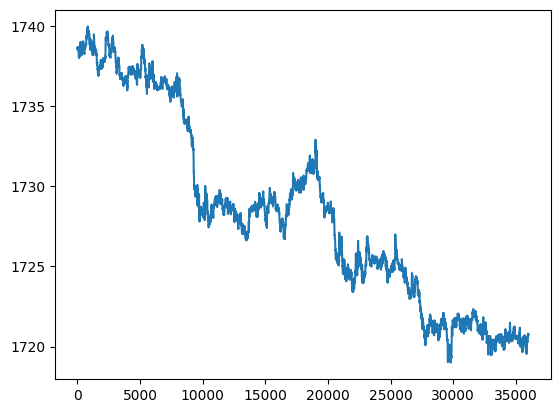

In [15]:
plt.plot(nm_data_raw[1]['S1 Z'])

### Load sound meta-data (order of songs for each group of study participants:

In [16]:
os.chdir(path_to_sound_meta_data)

In [17]:
song_order = pd.read_csv('nm15_song_order.csv')
song_order

,1,2,3,4,5
0,A,3,1,2,4
1,B,1,2,4,3
2,C,1,2,3,4
3,D,2,3,4,1
4,E,1,2,3,4
5,F,3,1,2,4
6,G,3,2,4,1
7,H,3,2,4,1
8,I,3,1,2,4
9,J,3,4,2,1


In [18]:
song_order.shape

(12, 5)

In [19]:
song_order.columns = ['groups', 2, 3, 4, 5]
song_order

,groups,2,3,4,5
0,A,3,1,2,4
1,B,1,2,4,3
2,C,1,2,3,4
3,D,2,3,4,1
4,E,1,2,3,4
5,F,3,1,2,4
6,G,3,2,4,1
7,H,3,2,4,1
8,I,3,1,2,4
9,J,3,4,2,1


In [20]:
song_order

,groups,2,3,4,5
0,A,3,1,2,4
1,B,1,2,4,3
2,C,1,2,3,4
3,D,2,3,4,1
4,E,1,2,3,4
5,F,3,1,2,4
6,G,3,2,4,1
7,H,3,2,4,1
8,I,3,1,2,4
9,J,3,4,2,1


Add a column of 1 (silence sound track) at the beginning and at the end of the data frame because each experiment started and ended with one minute of silence:

In [21]:
first_minute = [int(1)]*song_order.shape[0]
last_minute = [int(1)]*song_order.shape[0]

In [22]:
song_order.insert(1, 1, first_minute)
song_order.insert(song_order.shape[1], 6, last_minute)
song_order

,groups,1,2,3,4,5,6
0,A,1,3,1,2,4,1
1,B,1,1,2,4,3,1
2,C,1,1,2,3,4,1
3,D,1,2,3,4,1,1
4,E,1,1,2,3,4,1
5,F,1,3,1,2,4,1
6,G,1,3,2,4,1,1
7,H,1,3,2,4,1,1
8,I,1,3,1,2,4,1
9,J,1,3,4,2,1,1


Replace the letters that designate the experimental groups with numbers:

In [23]:
song_order.groups = list(range(1,13))
song_order

,groups,1,2,3,4,5,6
0,1,1,3,1,2,4,1
1,2,1,1,2,4,3,1
2,3,1,1,2,3,4,1
3,4,1,2,3,4,1,1
4,5,1,1,2,3,4,1
5,6,1,3,1,2,4,1
6,7,1,3,2,4,1,1
7,8,1,3,2,4,1,1
8,9,1,3,1,2,4,1
9,10,1,3,4,2,1,1


### Attribute sound track number to the time series data:

In [24]:
def attribute_sound_track_labels(sound_track_order, data_dict):
    for number in sound_track_order.groups:

        # Select the row corresponding to one groups: 
        selection_bools = sound_track_order.groups == number
        song_order_group = sound_track_order[selection_bools]
        #print(song_order[selection_bools].iloc[0,:])
        # Make an empty list to store all the labels in: 
        song_labels = []
        # Loop through all the elements in the row corresponding to one group:
        for song_number in song_order_group.iloc[0,1:]:
    
            # Make a list with the label of the corresponding
            # sound track of the same length as the corresponding
            # time series:
            labels = [song_number]*6000
    
            # Add the list with the one label to the list
            # that is going to contain all labels:
            song_labels.extend(labels)
    
        # Add the list with all labels to the data frame of
        # one experimental group as a target column:
        data_dict[number]['target'] = song_labels
    return data_dict

In [25]:
nm_data_raw = attribute_sound_track_labels(song_order, nm_data_raw)

In [26]:
nm_data_raw[1].head()

,S1 X,S1 Y,S1 Z,S2 X,S2 Y,S2 Z,S3 X,S3 Y,S3 Z,S4 X,...,Corner2 X,Corner2 Y,Corner2 Z,Corner3 X,Corner3 Y,Corner3 Z,Corner4 X,Corner4 Y,Corner4 Z,target
0,-1132.908,1053.272,1738.612,-577.677,983.700,1680.741,319.148,1002.059,1793.367,1323.212,...,2164.907,1504.309,1859.115,2079.816,-1237.564,1874.537,-1678.877,-1008.469,1870.884,1
1,-1132.979,1053.367,1738.614,-577.466,983.874,1680.804,319.131,1001.943,1793.363,1321.374,...,2164.909,1504.296,1859.115,2079.834,-1237.573,1874.530,-1678.953,-1008.503,1870.912,1
2,-1133.041,1053.458,1738.627,-577.294,984.055,1680.878,319.120,1001.800,1793.369,1321.383,...,2164.942,1504.317,1859.114,2079.857,-1237.581,1874.560,-1678.953,-1008.503,1870.912,1
3,-1133.070,1053.473,1738.604,-577.121,984.249,1680.953,319.087,1001.616,1793.341,1321.124,...,2164.932,1504.229,1859.118,2079.720,-1237.606,1874.586,-1678.955,-1008.444,1870.999,1
4,-1133.117,1053.564,1738.602,-576.947,984.451,1680.971,319.006,1001.445,1793.341,1321.112,...,2164.930,1504.208,1859.116,2079.818,-1237.633,1874.624,-1678.955,-1008.444,1870.999,1


In [27]:
x_columns = []
for element in nm_data_raw[1].columns:
    if 'X' in element:
        print(element)
        x_columns.append(element)

S1 X
S2 X
S3 X
S4 X
S5 X
S6 X
S7 X
S8 X
S9 X
S10 X
S11 X
S12 X
Corner1 X
Corner2 X
Corner3 X
Corner4 X


## Take all data from sound track silence and put them into one data frame:

In [28]:
CLASS_NORMAL = 1

frames_to_stack = []
for key, data_group in nm_data_raw.items():
    
    selection_bools = data_group.target == CLASS_NORMAL
    normal_data_group = data_group[selection_bools]

    x_columns = []
    for element in normal_data_group.columns:
        if 'X' in element:
            #print(element)
            x_columns.append(element)
    columns_to_select = x_columns + ['target']
    
    normal_data_group_1d = normal_data_group.loc[:,columns_to_select]
    print(normal_data_group_1d.shape)
    frames_to_stack.append(normal_data_group_1d)
    
normal_data_all_1d = pd.concat(frames_to_stack)  

In [29]:
def take_data_with_label_or_not(data_dict, label, with_label = True):
    frames_to_stack = []
    for key, data_group in nm_data_raw.items():

        if with_label == True:
            selection_bools = data_group.target == label
        else:
            selection_bools = data_group.target != label
        normal_data_group = data_group[selection_bools]
    
        x_columns = []
        for element in normal_data_group.columns:
            if 'X' in element:
                #print(element)
                x_columns.append(element)
        columns_to_select = x_columns + ['target']
        
        normal_data_group_1d = normal_data_group.loc[:,columns_to_select]
        print(normal_data_group_1d.shape)
        frames_to_stack.append(normal_data_group_1d)
        
    normal_data_all_1d = pd.concat(frames_to_stack) 
    return normal_data_all_1d

In [31]:
nm_data_raw_1 = nm_data_raw[1].copy()

In [32]:

#normal_data_all_1d = take_data_with_label_or_not(nm_data_raw, CLASS_NORMAL)

normal_data_all_1d = take_data_with_label_or_not(nm_data_raw_1, CLASS_NORMAL)

(18000, 17)
(18000, 12)
(18000, 14)
(18000, 16)
(18000, 16)
(18000, 13)
(18000, 15)
(18000, 8)
(18000, 16)
(18000, 13)
(18000, 15)
(18000, 6)


In [33]:
normal_data_all_1d.head()

,S1 X,S2 X,S3 X,S4 X,S5 X,S6 X,S7 X,S8 X,S9 X,S10 X,S11 X,S12 X,Corner1 X,Corner2 X,Corner3 X,Corner4 X,target
0,-1132.908,-577.677,319.148,1323.212,-1184.425,-327.140,522.711,1334.210,-1283.543,-313.999,518.993,1350.808,-1563.808,2164.907,2079.816,-1678.877,1
1,-1132.979,-577.466,319.131,1321.374,-1184.403,-326.955,522.756,1334.231,-1283.653,-314.005,519.038,1350.901,-1563.821,2164.909,2079.834,-1678.953,1
2,-1133.041,-577.294,319.120,1321.383,-1184.367,-326.757,522.773,1334.269,-1283.615,-314.042,519.087,1350.980,-1563.805,2164.942,2079.857,-1678.953,1
3,-1133.070,-577.121,319.087,1321.124,-1184.307,-326.536,522.807,1334.260,-1283.641,-314.076,519.123,1350.993,-1563.805,2164.932,2079.720,-1678.955,1
4,-1133.117,-576.947,319.006,1321.112,-1184.249,-326.348,522.831,1334.267,-1283.600,-314.057,519.165,1351.058,-1563.805,2164.930,2079.818,-1678.955,1


In [34]:
set(normal_data_all_1d.target)

{1}

In [35]:
normal_data_all_1d.reset_index(inplace=True, drop=True)

Transpose the data frame by sound track length (each batch of data corresponding to one sound track has to be transposed individually because one row should contain the time series corresponding to one sound track:

In [36]:
def transpose_by_minute(data):
    '''Transpose the data frame by sound track length 
    (each batch of data corresponding to one sound 
    track has to be transposed individually because one row should 
    contain the time series corresponding to one sound track:'''
    indices = list(np.arange(0, data.shape[0]+1, 6000))
    indices
    list_of_frames = []
    for num in range(0, len(indices)-1):
        data_num = data.iloc[indices[num]:indices[num+1],:]
        data_values = data_num.iloc[:,:-1]
        data_t = data_values.T
        data_t.columns = list(range(0, 6000))
        #print(data.iloc[:,:])
        list_of_frames.append(data_t.iloc[:,:])
    data_t = pd.concat(list_of_frames, axis=0)
    return data_t

In [37]:
normal_data_all_1d_t = transpose_by_minute(normal_data_all_1d)
normal_data_all_1d_t.head()

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
S1 X,-1132.908,-1132.979,-1133.041,-1133.070,-1133.117,-1133.110,-1133.115,-1133.159,-1133.185,-1133.216,...,-1134.592,-1134.635,-1134.727,-1134.805,-1134.750,-1134.856,-1135.040,-1135.126,-1135.225,-1135.317
S2 X,-577.677,-577.466,-577.294,-577.121,-576.947,-576.829,-576.828,-576.588,-576.494,-576.402,...,-581.431,-581.390,-581.369,-581.332,-581.302,-581.301,-581.279,-581.257,-581.229,-581.209
S3 X,319.148,319.131,319.120,319.087,319.006,318.800,318.751,318.674,318.550,318.401,...,337.239,337.249,337.285,337.288,337.322,337.337,337.329,337.352,337.352,337.349
S4 X,1323.212,1321.374,1321.383,1321.124,1321.112,1321.037,1321.344,1320.960,1320.915,1320.860,...,1312.025,1312.038,1312.052,1312.065,1312.058,1312.050,1312.061,1312.082,1312.071,1312.074
S5 X,-1184.425,-1184.403,-1184.367,-1184.307,-1184.249,-1184.142,-1184.196,-1184.157,-1184.111,-1184.065,...,-1182.241,-1182.208,-1182.184,-1182.161,-1182.127,-1182.110,-1182.094,-1182.065,-1182.046,-1182.023


## Take all data from music sound tracks and put them into one data frame:

In [39]:

anomaly_data_all_1d = take_data_with_label_or_not(nm_data_raw_1, CLASS_NORMAL, with_label=False)

#anomaly_data_all_1d = take_data_with_label_or_not(nm_data_raw, CLASS_NORMAL, with_label=False)

(18000, 17)
(18000, 12)
(18000, 14)
(18000, 16)
(18000, 16)
(18000, 13)
(18000, 15)
(18000, 8)
(18000, 16)
(18000, 13)
(18000, 15)
(18000, 6)


In [40]:
anomaly_data_all_1d.head()

,S1 X,S2 X,S3 X,S4 X,S5 X,S6 X,S7 X,S8 X,S9 X,S10 X,S11 X,S12 X,Corner1 X,Corner2 X,Corner3 X,Corner4 X,target
6000,-1135.417,-581.169,337.342,1312.071,-1182.022,-328.498,534.816,1303.885,-1270.408,-325.499,514.917,1362.108,-1563.805,2164.960,2079.833,-1678.990,3
6001,-1135.517,-581.145,337.331,1312.096,-1182.018,-328.457,534.877,1303.979,-1270.378,-325.472,514.857,1361.983,-1563.808,2164.925,2079.865,-1678.977,3
6002,-1135.610,-581.119,337.333,1312.137,-1182.009,-328.433,534.960,1304.035,-1270.366,-325.472,514.811,1361.996,-1563.805,2164.960,2079.825,-1678.937,3
6003,-1135.689,-581.093,337.350,1312.185,-1182.007,-328.402,535.081,1304.093,-1270.462,-325.476,514.751,1362.051,-1563.818,2164.936,2079.873,-1678.990,3
6004,-1135.736,-581.071,337.347,1312.176,-1182.003,-328.384,535.169,1304.146,-1270.358,-325.436,514.700,1362.118,-1563.805,2164.971,2079.814,-1678.937,3


In [41]:
set(anomaly_data_all_1d.target)

{2, 3, 4}

In [42]:
anomaly_data_all_1d.reset_index(inplace=True, drop=True)

In [43]:
anomaly_data_all_1d_t = transpose_by_minute(anomaly_data_all_1d)
anomaly_data_all_1d_t.head()

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
S1 X,-1135.417,-1135.517,-1135.610,-1135.689,-1135.736,-1135.798,-1135.838,-1135.877,-1135.884,-1135.881,...,-1127.286,-1127.288,-1127.306,-1127.346,-1127.385,-1127.435,-1127.498,-1127.554,-1127.608,-1127.691
S2 X,-581.169,-581.145,-581.119,-581.093,-581.071,-581.058,-581.044,-581.027,-580.969,-580.919,...,-590.033,-590.033,-590.015,-589.993,-589.988,-589.989,-589.981,-589.991,-590.006,-590.014
S3 X,337.342,337.331,337.333,337.350,337.347,337.385,337.418,337.496,337.573,337.663,...,331.869,331.833,331.777,331.721,331.691,331.628,331.565,331.568,331.535,331.528
S4 X,1312.071,1312.096,1312.137,1312.185,1312.176,1312.221,1312.261,1312.326,1312.366,1312.404,...,1309.995,1309.984,1310.026,1310.019,1310.031,1310.042,1310.034,1310.040,1310.037,1310.041
S5 X,-1182.022,-1182.018,-1182.009,-1182.007,-1182.003,-1182.020,-1182.031,-1182.038,-1182.043,-1182.041,...,-1183.275,-1183.188,-1183.122,-1183.035,-1182.977,-1182.933,-1182.869,-1182.825,-1182.798,-1182.754


In [44]:
normal_df = normal_data_all_1d_t.copy()
anomaly_df = anomaly_data_all_1d_t.copy()

In [45]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [46]:
train_df, val_df = train_test_split(

  normal_df,

  test_size=0.15,

  random_state=RANDOM_SEED

)

val_df, test_df = train_test_split(

  val_df,

  test_size=0.33,

  random_state=RANDOM_SEED

)

In [47]:
print(normal_data_all_1d_t.shape)
print(normal_df.shape)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(576, 6000)
(576, 6000)
(489, 6000)
(58, 6000)
(29, 6000)


In [48]:
489 +58 +29

576

In [49]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [50]:
train_dataset, seq_len, n_features = create_dataset(train_df)

val_dataset, _, _ = create_dataset(val_df)

test_normal_dataset, _, _ = create_dataset(test_df)

test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [ ]:
train_raw = io.arff.loadarff('ECG5000_TRAIN.arff')
test_raw = io.arff.loadarff('ECG5000_TEST.arff')

In [ ]:
print(len(train_raw[0]))
print(len(test_raw[0]))

In [ ]:
column_names_train = train_raw[1]
data_train = train_raw[0]
column_names_test = test_raw[1]
data_test = test_raw[0]

In [ ]:
df_train = pd.DataFrame(data_train, columns=column_names_train)
df_test = pd.DataFrame(data_test, columns=column_names_test)

In [ ]:
df_train.shape

In [ ]:
df_test.shape

In [ ]:
type(df_train)

We'll combine the training and test data into a single data frame. This will give us more data to train our Autoencoder. We'll also shuffle it: 

#### Introduce some shuffling!

In [ ]:
df = pd.concat([df_train, df_test], ignore_index=True, axis=0)

In [ ]:
type(df)

In [ ]:
df.shape

In [ ]:
df.head(10)

We have 5,000 examples. Each row represents a single heartbeat record. Let's name the possible classes:

In [ ]:
CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

Next, we'll rename the last column to `target`, so its easier to reference it:

In [ ]:
new_columns = list(df.columns)

new_columns[-1] = 'target'

df.columns = new_columns

In [ ]:
df.shape

In [ ]:
df.head()

## Exploratory Data Analysis

Let's check how many examples for each heartbeat class do we have:

In [ ]:
df.target.value_counts()

In [ ]:
target_list = []
for index, row in df.iterrows():
    target_as_string = row.target.decode("utf-8")
    #print(target_as_string)
    #print(int(target_as_string))
    target_list.append(int(target_as_string))

df.target = target_list

In [ ]:
df.head()

In [ ]:
ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);

In [ ]:
df.target.value_counts()

In [ ]:
df.sort_index()

The normal class, has by far, the most examples. This is great because we'll use it to train our model.

Let's have a look at an averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:

In [ ]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

In [ ]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

It is very good that the normal class has a distinctly different pattern than all other classes. Maybe our model will be able to detect anomalies?

## LSTM Autoencoder

The [Autoencoder's](https://en.wikipedia.org/wiki/Autoencoder) job is to get some input data, pass it through the model, and obtain a reconstruction of the input. The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, so your model learns a compressed representation of the data.

In a sense, Autoencoders try to learn only the most important features (compressed version) of the data. Here, we'll have a look at how to feed Time Series data to an Autoencoder. We'll use a couple of LSTM layers (hence the LSTM Autoencoder) to capture the temporal dependencies of the data.

To classify a sequence as normal or an anomaly, we'll pick a threshold above which a heartbeat is considered abnormal.

### Reconstruction Loss

When training an Autoencoder, the objective is to reconstruct the input as best as possible. This is done by minimizing a loss function (just like in supervised learning). This function is known as *reconstruction loss*. Cross-entropy loss and Mean squared error are common examples.

## Anomaly Detection in ECG Data

We'll use normal heartbeats as training data for our model and record the *reconstruction loss*. But first, we need to prepare the data:

### Data Preprocessing

Let's get all normal heartbeats and drop the target (class) column:

We'll merge all other classes and mark them as anomalies:

In [ ]:
type(df.target[0])

In [ ]:
df.target[0] == CLASS_NORMAL

In [ ]:
CLASS_NORMAL == 1

In [ ]:
normal_df = df[df.target == CLASS_NORMAL].drop(labels='target', axis=1)

normal_df.shape

We'll merge all other classes and mark them as anomalies:

In [ ]:
anomaly_df = df[df.target != CLASS_NORMAL].drop(labels='target', axis=1)

anomaly_df.shape

We'll split the normal examples into train, validation 
and test sets:

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
train_df, val_df = train_test_split(

  normal_df,

  test_size=0.15,

  random_state=RANDOM_SEED

)

val_df, test_df = train_test_split(

  val_df,

  test_size=0.33,

  random_state=RANDOM_SEED

)

We need to convert our examples into tensors, so we can use them to train our Autoencoder. Let's write a helper function for that:

In [ ]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape *sequence length* x *number of features* (140x1 in our case).

Let's create some datasets:

In [ ]:
train_dataset, seq_len, n_features = create_dataset(train_df)

val_dataset, _, _ = create_dataset(val_df)

test_normal_dataset, _, _ = create_dataset(test_df)

test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)
*Sample Autoencoder Architecture [Image Source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)*

The general Autoencoder architecture consists of two components. An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.

We'll use the LSTM Autoencoder from this [GitHub repo](https://github.com/shobrook/sequitur) with some small tweaks. Our model's job is to reconstruct Time Series data. Let's start with the *Encoder*:

In [51]:
sequences = train_df.astype(np.float32).to_numpy().tolist()

In [52]:
type(sequences)

list

In [53]:
len(sequences)

489

In [54]:
type(sequences[0])

list

In [55]:
len(sequences[0])

6000

In [56]:
train_df.shape

(489, 6000)

In [57]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):

    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features

    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(

      input_size=n_features,

      hidden_size=self.hidden_dim,

      num_layers=1,

      batch_first=True

    )

    self.rnn2 = nn.LSTM(

      input_size=self.hidden_dim,

      hidden_size=embedding_dim,

      num_layers=1,

      batch_first=True

    )

  def forward(self, x):

    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)

    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

The *Encoder* uses two LSTM layers to compress the Time Series data input.

Next, we'll decode the compressed representation using a *Decoder*:

In [58]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):

    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim

    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(

      input_size=input_dim,

      hidden_size=input_dim,

      num_layers=1,

      batch_first=True

    )

    self.rnn2 = nn.LSTM(

      input_size=input_dim,

      hidden_size=self.hidden_dim,

      num_layers=1,

      batch_first=True

    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):

    x = x.repeat(self.seq_len, self.n_features)

    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)

    x, (hidden_n, cell_n) = self.rnn2(x)

    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

Our Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

Time to wrap everything into an easy to use module:

In [59]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):

    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)

    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):

    x = self.encoder(x)

    x = self.decoder(x)

    return x

Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:

In [60]:
model = RecurrentAutoencoder(seq_len, n_features, 128)

model = model.to(device)

In [61]:
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

## Training

Let's write a helper function for our training process:

In [62]:
def train_model(model, train_dataset, val_dataset, n_epochs):

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

  criterion = nn.L1Loss(reduction='sum').to(device)

  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())

  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):

    model = model.train()

    train_losses = []

    for seq_true in train_dataset:

      optimizer.zero_grad()

      seq_true = seq_true.to(device)

      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()

      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []

    model = model.eval()

    with torch.no_grad():

      for seq_true in val_dataset:

        seq_true = seq_true.to(device)

        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)

        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)

    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)

    history['val'].append(val_loss)

    if val_loss < best_loss:

      best_loss = val_loss

      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)

  return model.eval(), history

At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

Note that we're minimizing the L1Loss, which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

We'll get the version of the model with the smallest validation error. Let's do some training:


In [ ]:
model, history = train_model(

  model,

  train_dataset,

  val_dataset,

  n_epochs=150

)

Epoch 1: train loss nan val loss nan


In [ ]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

Our model converged quite well. Seems like we might've needed a larger validation set to smoothen the results, but that'll do for now.

## Saving the model

Let's store the model for later use:

In [ ]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

Uncomment the next lines, if you want to download and load the pre-trained model:

In [ ]:
# !gdown --id 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
# model = torch.load('model.pth')
# model = model.to(device)

## Choosing a threshold

With our model at hand, we can have a look at the reconstruction error on the training set. Let's start by writing a helper function to get predictions from our model:

In [ ]:
def predict(model, dataset):

  predictions, losses = [], []

  criterion = nn.L1Loss(reduction='sum').to(device)

  with torch.no_grad():

    model = model.eval()

    for seq_true in dataset:

      seq_true = seq_true.to(device)

      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())

      losses.append(loss.item())

  return predictions, losses

Our function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them:

In [ ]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [ ]:
THRESHOLD = 26

## Evaluation

Using the threshold, we can turn the problem into a simple binary classification task:

- If the reconstruction loss for an example is below the threshold, we'll classify it as a *normal* heartbeat
- Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

### Normal hearbeats

Let's check how well our model does on normal heartbeats. We'll use the normal heartbeats from the test set (our model haven't seen those):

In [ ]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

We'll count the correct predictions:

In [ ]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

### Anomalies
We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal heartbeats:

In [ ]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

Now we can take the predictions of our model for the subset of anomalies:

In [ ]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

Finally, we can count the number of examples above the threshold (considered as anomalies):

In [ ]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

We have very good results. In the real world, you can tweak the threshold depending on what kind of errors you want to tolerate. In this case, you might want to have more false positives (normal heartbeats considered as anomalies) than false negatives (anomalies considered as normal).

#### Looking at Examples

We can overlay the real and reconstructed Time Series values to see how close they are. We'll do it for some normal and anomaly cases:

In [ ]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

In [ ]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

## Summary

In this tutorial, you learned how to create an LSTM Autoencoder with PyTorch and use it to detect heartbeat anomalies in ECG data.

- [Read the tutorial](https://www.curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1_J2MrBSvsJfOcVmYAN2-WSp36BtsFZCa)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Prepare a dataset for Anomaly Detection from Time Series Data
- Build an LSTM Autoencoder with PyTorch
- Train and evaluate your model
- Choose a threshold for anomaly detection
- Classify unseen examples as normal or anomaly

While our Time Series data is univariate (we have only 1 feature), the code should work for multivariate datasets (multiple features) with little or no modification. Feel free to try it!

## References

- [Sequitur - Recurrent Autoencoder (RAE)](https://github.com/shobrook/sequitur)
- [Towards Never-Ending Learning from Time Series Streams](https://www.cs.ucr.edu/~eamonn/neverending.pdf)
- [LSTM Autoencoder for Anomaly Detection](https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf)